<center>

# **如何进行GLM 一阶分析 (基于surface空间)**

</center>

***

基于surface空间的GLM一阶分析代码，以NARPS数据集中的被试数据为例进行演示。

本教程展示了如何在大脑皮层表面空间中进行fMRI数据的一阶GLM分析，包括参数调制(parametric modulation)分析。

**参考资料：**
- [Nilearn Surface-based GLM Analysis](https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_localizer_surface_analysis.html)
- [NARPS数据集描述](https://www.nature.com/articles/s41586-020-2314-9)


In [12]:
# 导入所需的库
import os
import pandas as pd
import numpy as np
import os.path as op
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import nibabel as nb
from nilearn.glm.first_level import make_first_level_design_matrix, run_glm
from nilearn.glm.contrasts import compute_contrast

# 用于计算不同条件之间的对比
from itertools import combinations 

from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

In [13]:
# 定义函数，根据头动参数（帧位移与六个方向的运动参数）识别头动过大的时间点并删除
def motion_controlled_event_timetable(event_table, fd_data, six_absolute_motion, TR, FD_thr, ab_motion_thr):
    # 检测超出帧位移（FD）阈值的时间点
    out_motion_detect = fd_data.to_numpy().flatten() > FD_thr
    out_motion_index = np.where(out_motion_detect)[0]
    # 检测超过绝对运动阈值的时间点
    six_motion_ex = np.where(np.any(np.abs(six_absolute_motion) > ab_motion_thr, axis=1))[0]
    
    # 将运动时间点通过乘以 TR 转换为实际时间
    out_motion_time = np.array([])
    if len(out_motion_index) > 0:
        out_motion_time = (out_motion_index + 1) * TR
    if len(six_motion_ex) > 0:
        six_motion_time = (six_motion_ex + 1) * TR
        out_motion_time = np.concatenate((out_motion_time, six_motion_time), axis=0)
        out_motion_time = np.unique(out_motion_time)
    
    # 为事件表添加一个新列'time_end'，计算每个事件的结束时间
    # 使用lambda函数计算：结束时间 = 开始时间(onset) + 持续时间(duration)
    tmp_timetable = event_table.assign(time_end=lambda dataframe: dataframe['onset'] + dataframe['duration'])
    tmp_timetable = tmp_timetable.reset_index(drop=True)
    
    # 标记运动超过阈值的时间点
    block_time_judge = np.zeros(tmp_timetable.shape[0])
    block_time_in = np.zeros(tmp_timetable.shape[0])
    try:
        for n_time in range(tmp_timetable.shape[0]):
            for i in out_motion_time:
                time_judge_0 = (i <= tmp_timetable.loc[n_time, 'time_end'])
                block_time_judge[n_time] += time_judge_0
                time_judge_1 = (i <= tmp_timetable.loc[n_time, 'time_end']) and (i >= tmp_timetable.loc[n_time, 'onset'])
                block_time_in[n_time] += time_judge_1
            
        tmp_timetable = tmp_timetable.assign(
            time_delete=block_time_judge * TR,
            delete_time_inblock=block_time_in
        )
        tmp_timetable.loc[:, 'duration'] = tmp_timetable['duration'] - tmp_timetable['delete_time_inblock'] * TR
        
        # 调整起始时间 (onset) 并重新计算结束时间
        for n_time in range(tmp_timetable.shape[0]):
            if n_time != 0:
                tmp_timetable.loc[n_time, 'onset'] = tmp_timetable.loc[n_time, 'onset'] - tmp_timetable.loc[n_time, 'time_delete']
            tmp_timetable.loc[n_time, 'time_end'] = tmp_timetable.loc[n_time, 'onset'] + tmp_timetable.loc[n_time, 'duration']
    except Exception as e:
        print("Error in motion_controlled_event_timetable:", e)
        out_motion_time = False
        tmp_timetable = event_table
    return [tmp_timetable, out_motion_time]


In [14]:
# 定义函数，删除对应运动时间点的 GIFTI 时间点
def correct_motion_for_giidata(motion_corrected_path, subname, run, task_file_L, task_file_R, data_L_path, data_R_path, TR, out_motion_time):
    motion_corrected_subfolder = op.join(motion_corrected_path, subname)
    if not os.path.exists(motion_corrected_subfolder):
        os.makedirs(motion_corrected_subfolder)
    corrected_gii_file_L = op.join(motion_corrected_subfolder, subname + task_file_L)
    corrected_gii_file_R = op.join(motion_corrected_subfolder, subname + task_file_R)
    
    # 加载 GIFTI 数据
    data_L = nb.load(data_L_path)
    data_R = nb.load(data_R_path)

    # 计算需要删除的时间点
    timepoints_to_delete = ((out_motion_time / TR).astype(int)) - 1
    timepoints_to_keep = np.setdiff1d(np.arange(len(data_L.darrays)), timepoints_to_delete)

    # 创建新的 GIFTI 图像，包含选定的时间点
    corrected_darrays_L = [data_L.darrays[i] for i in timepoints_to_keep]
    corrected_darrays_R = [data_R.darrays[i] for i in timepoints_to_keep]
    
    corrected_data_L = nb.gifti.GiftiImage(darrays=corrected_darrays_L)
    corrected_data_R = nb.gifti.GiftiImage(darrays=corrected_darrays_R)
    
    # 保存校正后的 GIFTI 数据
    nb.save(corrected_data_L, corrected_gii_file_L)
    nb.save(corrected_data_R, corrected_gii_file_R)
    
    return corrected_gii_file_L, corrected_gii_file_R


In [15]:
# 设置根目录和数据路径
rootdir = '/Volumes/ss/ds001734'
# 可以根据需要修改被试列表(sublist)和run列表(runs)
# 这里只使用Narps数据中的第一个被试，一共是4次run
sublist = ['001'] 
runs = ['01', '02', '03', '04']
# task名称，可以根据实际数据修改
taskname = 'MGT'
# 根据你的数据修改TR时间
# 对于公开数据集，TR值通常可以在以下位置找到：
# 1. 原始论文的Methods部分
# 2. BIDS格式数据的task-*_bold.json文件中的"RepetitionTime"字段
TR = 1.0  
# 设置帧位移和绝对运动阈值，这是绝大多数研究中常用的阈值，你也可以根据实际情况进行调整
FD_thr = 0.2  
ab_motion_thr = 3  

# 设置输出路径
out_path = op.join(rootdir, 'derivatives', 'first_level_model_corrected_gii')
motion_corrected_path = op.join(rootdir, 'derivatives', 'motion_corrected_data_gii')

# 设置是否进行头动校正（删除头动过大的时间点）
# 设置为 False 可避免删除由于头动造成的运动伪影较大的时间帧
do_motion_exclusion = False 


[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_69646/846472784.py:120: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  plot_design_matrix(GLM_matrix_modulated,rescale=False, ax=ax)


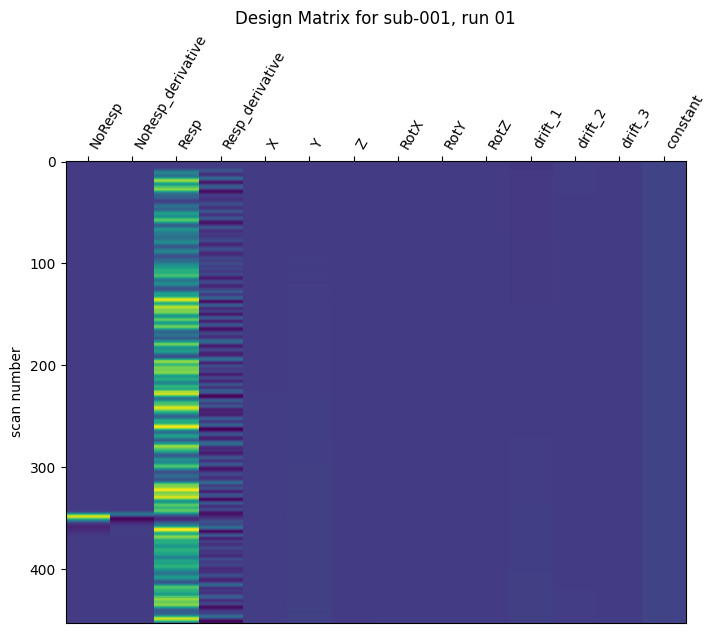

/Users/ss/miniconda3/envs/fmri_pipeline/lib/python3.12/site-packages/nilearn/glm/_utils.py:207: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


Contrast Resp for sub-001, run 01 completed and saved to /Volumes/ss/ds001734/derivatives/first_level_model_corrected_gii/sub-001/stats_results/run-01/sub-001_task-MGT_run-01_Resp_zmap.L.func.gii and /Volumes/ss/ds001734/derivatives/first_level_model_corrected_gii/sub-001/stats_results/run-01/sub-001_task-MGT_run-01_Resp_zmap.R.func.gii
Contrast NoResp for sub-001, run 01 completed and saved to /Volumes/ss/ds001734/derivatives/first_level_model_corrected_gii/sub-001/stats_results/run-01/sub-001_task-MGT_run-01_NoResp_zmap.L.func.gii and /Volumes/ss/ds001734/derivatives/first_level_model_corrected_gii/sub-001/stats_results/run-01/sub-001_task-MGT_run-01_NoResp_zmap.R.func.gii
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_69646/846472784.py:120: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  plot_design_matrix(GLM_matrix_modulated,rescale=False, ax=ax)


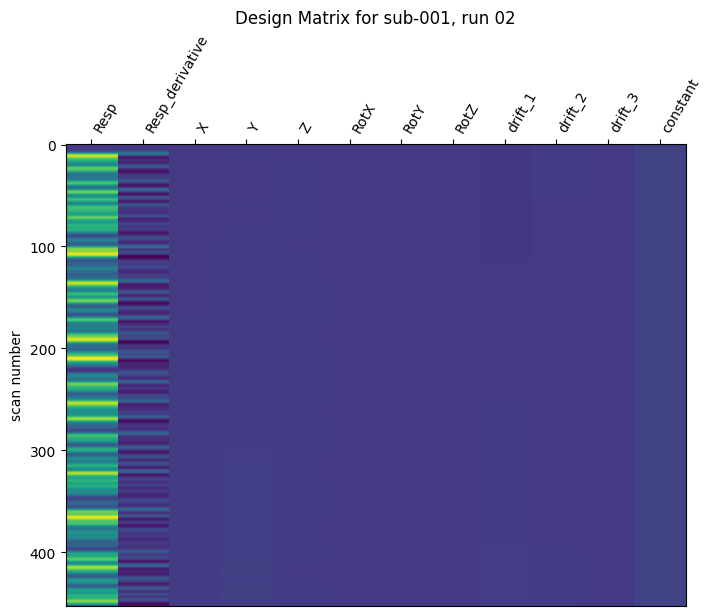

/Users/ss/miniconda3/envs/fmri_pipeline/lib/python3.12/site-packages/nilearn/glm/_utils.py:207: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


Contrast Resp for sub-001, run 02 completed and saved to /Volumes/ss/ds001734/derivatives/first_level_model_corrected_gii/sub-001/stats_results/run-02/sub-001_task-MGT_run-02_Resp_zmap.L.func.gii and /Volumes/ss/ds001734/derivatives/first_level_model_corrected_gii/sub-001/stats_results/run-02/sub-001_task-MGT_run-02_Resp_zmap.R.func.gii
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_69646/846472784.py:120: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  plot_design_matrix(GLM_matrix_modulated,rescale=False, ax=ax)


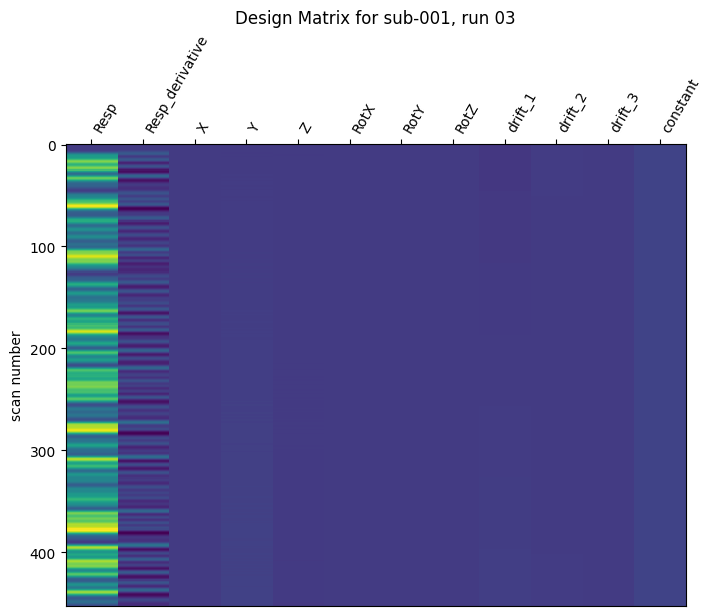

/Users/ss/miniconda3/envs/fmri_pipeline/lib/python3.12/site-packages/nilearn/glm/_utils.py:207: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


Contrast Resp for sub-001, run 03 completed and saved to /Volumes/ss/ds001734/derivatives/first_level_model_corrected_gii/sub-001/stats_results/run-03/sub-001_task-MGT_run-03_Resp_zmap.L.func.gii and /Volumes/ss/ds001734/derivatives/first_level_model_corrected_gii/sub-001/stats_results/run-03/sub-001_task-MGT_run-03_Resp_zmap.R.func.gii
[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_69646/846472784.py:120: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  plot_design_matrix(GLM_matrix_modulated,rescale=False, ax=ax)


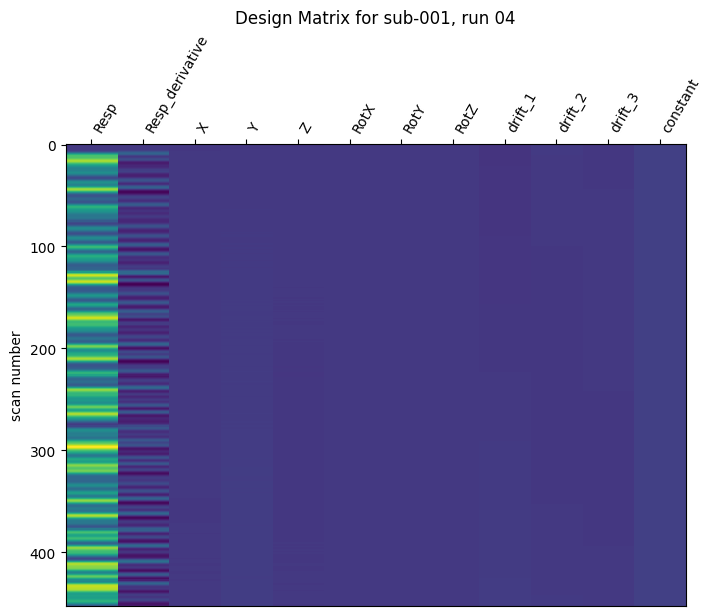

Contrast Resp for sub-001, run 04 completed and saved to /Volumes/ss/ds001734/derivatives/first_level_model_corrected_gii/sub-001/stats_results/run-04/sub-001_task-MGT_run-04_Resp_zmap.L.func.gii and /Volumes/ss/ds001734/derivatives/first_level_model_corrected_gii/sub-001/stats_results/run-04/sub-001_task-MGT_run-04_Resp_zmap.R.func.gii


/Users/ss/miniconda3/envs/fmri_pipeline/lib/python3.12/site-packages/nilearn/glm/_utils.py:207: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


In [22]:
# 主要代码：GLM一阶分析的核心循环
# 遍历每个被试和每个run，进行独立的一阶分析

for sub in sublist:
    subname = 'sub-' + sub
    subeventdir = op.join(rootdir, subname, 'func')
    subimagedir = op.join(rootdir, 'derivatives', 'fmriprep', subname, 'func')
    for run in runs:
        sub_event_file = op.join(subeventdir, f'{subname}_task-{taskname}_run-{run}_events.tsv')
        sub_gii_file_L = op.join(subimagedir, f'{subname}_task-{taskname}_run-{run}_bold_space-fsaverage5.L.func.gii')
        sub_gii_file_R = op.join(subimagedir, f'{subname}_task-{taskname}_run-{run}_bold_space-fsaverage5.R.func.gii')
        sub_motioninfo_file = op.join(subimagedir, f'{subname}_task-{taskname}_run-{run}_bold_confounds.tsv')

        # 检查所需文件是否存在
        # 如果缺少任何文件，则跳过该被试和该run
        if not (os.path.exists(sub_event_file) and os.path.exists(sub_gii_file_L) and os.path.exists(sub_gii_file_R) and os.path.exists(sub_motioninfo_file)):
            print(f"Missing files for {subname}, run {run}")
            continue

        # 读取事件文件数据
        event_data = pd.read_csv(sub_event_file, sep='\t')
        # 将'participant_response' 重命名为'trial_type'
        # 将event文件中被试反应的数据重新编码为两种trial_type
        # 如果被试没有反应（'NoResp'），则标记为 'NoResp'；如果被试有反应（任何非'NoResp'的值），则标记为 'Resp'
        event_data['trial_type'] = event_data['participant_response'].apply(
            lambda x: 'NoResp' if x == 'NoResp' else 'Resp'
        )

        # 确保'gain'列作为 modulation effect 
        if 'gain' not in event_data.columns:
            print(f"'gain' column not found in {sub_event_file}")
            continue
        else:
            event_data.rename(columns={'gain': 'modulation'}, inplace=True)

        # 读取confounds文件，包含帧位移和六个方向的头动参数
        confounds = pd.read_csv(sub_motioninfo_file, sep='\t')
        # 处理缺失值
        confounds = confounds.fillna(0)

        # 获取帧位移（FD）数据
        if 'FramewiseDisplacement' in confounds.columns:
            fd = confounds[['FramewiseDisplacement']]
        elif 'framewise_displacement' in confounds.columns:
            fd = confounds[['framewise_displacement']]
        else:
            print(f"FD column not found in {sub_motioninfo_file}")
            continue

        # 获取六个方向的头动参数数据
        motion_params = confounds[['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']]

        # 头动校正
        # 如果设置了 do_motion_exclusion 为 True，则进行头动校正
        # 这将删除头动过大的时间点，并返回校正后的事件数据
        if do_motion_exclusion:
            [event_data_corrected, out_motion_time] = motion_controlled_event_timetable(event_data, fd, motion_params, TR, FD_thr, ab_motion_thr)
            # 保存校正后的 events 数据
            out_sub_path = op.join(out_path, subname)
            if not os.path.exists(out_sub_path):
                os.makedirs(out_sub_path)
            event_out_file = op.join(out_sub_path, f'{subname}_task-{taskname}_run-{run}_events_corrected.tsv')
            event_data_corrected.to_csv(event_out_file, sep='\t', index=False)
            # 校正 GIFTI 数据
            if not isinstance(out_motion_time, bool):
                task_file_L = f'_task-{taskname}_run-{run}_bold_space-fsaverage5.L.func.gii'
                task_file_R = f'_task-{taskname}_run-{run}_bold_space-fsaverage5.R.func.gii'
                corrected_gii_file_L, corrected_gii_file_R = correct_motion_for_giidata(
                    motion_corrected_path, subname, run, task_file_L, task_file_R, 
                    sub_gii_file_L, sub_gii_file_R, TR, out_motion_time
                )
                data_L = nb.load(corrected_gii_file_L)
                data_R = nb.load(corrected_gii_file_R)
                # 计算需要删除的时间点
                timepoints_to_delete = ((out_motion_time / TR).astype('int64')) - 1
                motion_params_corrected = motion_params.drop(motion_params.index[timepoints_to_delete]).reset_index(drop=True)
            else:
                data_L = nb.load(sub_gii_file_L)
                data_R = nb.load(sub_gii_file_R)
                motion_params_corrected = motion_params
                event_data_corrected = event_data
        else:
            event_data_corrected = event_data
            data_L = nb.load(sub_gii_file_L)
            data_R = nb.load(sub_gii_file_R)
            motion_params_corrected = motion_params

        # 将左右半球的数据合并为一个矩阵
        n_timepoints = len(data_L.darrays)
        n_vertices_L = data_L.darrays[0].data.shape[0]
        n_vertices_R = data_R.darrays[0].data.shape[0]

        # 构建一个二维零矩阵(data_matrix)，行数为n_timepoints，列数为左右脑半球的顶点数之和
        data_matrix = np.zeros((n_timepoints, n_vertices_L + n_vertices_R))
        for t in range(n_timepoints):
            data_L_t = data_L.darrays[t].data
            data_R_t = data_R.darrays[t].data
            data_matrix[t, :n_vertices_L] = data_L_t
            data_matrix[t, n_vertices_L:] = data_R_t

        frame_times = TR * (np.arange(n_timepoints))
        
        # 手动构建设计矩阵
        # 考虑了大脑活动是否会随modulation参数而变化，需要将'modulation'列添加到设计矩阵中）
        modulated_matrix = event_data_corrected[['onset', 'duration', 'trial_type', 'modulation']]
        
        # 构建调制的设计矩阵
        GLM_matrix_modulated = make_first_level_design_matrix(
            frame_times,
            modulated_matrix,
            drift_model='polynomial',
            drift_order=3,
            add_regs=motion_params_corrected,
            add_reg_names=motion_params_corrected.columns,
            hrf_model='spm + derivative'
        )

        # 可选：可视化设计矩阵
        fig, ax = plt.subplots(figsize=(8, 6))
        plot_design_matrix(GLM_matrix_modulated,rescale=False, ax=ax)
        ax.set_title(f'Design Matrix for {subname}, run {run}', fontsize=12)
        plt.show()

        # 进行 GLM 分析
        # 不要转置 data_matrix；Y 应该具有形状 (n_samples, n_voxels)
        # run_glm 函数返回 labels 和 estimates
        labels, estimates = run_glm(data_matrix, GLM_matrix_modulated.values)

        # 定义对比条件
        conditions = event_data_corrected['trial_type'].unique()
        design_columns = GLM_matrix_modulated.columns

        # 为每个条件创建一个对比向量
        contrasts = {}
        for cond in conditions:
            # 对应该条件的列
            cond_vector = np.array([1 if cond == col else 0 for col in design_columns])
            contrasts[cond] = cond_vector

        # 创建输出目录
        out_sub_path = op.join(out_path, subname)
        stats_results_path = op.join(out_sub_path, 'stats_results', f'run-{run}')
        if not os.path.exists(stats_results_path):
            os.makedirs(stats_results_path)

        # 计算每个条件与基线的对比
        for contrast_id, contrast_val in contrasts.items():
            contrast = compute_contrast(labels, estimates, contrast_val)
            # 计算 Z-map
            z_map = contrast.z_score()

            # z_map 是形状为 (n_voxels,)，即一维数组包含所有体素/顶点的z值
            # 将 z_map 重新分割为左右半球
            z_map_L = z_map[:n_vertices_L]
            z_map_R = z_map[n_vertices_L:]

            # 创建 GIFTI 数据数组
            z_map_L_darray = nb.gifti.GiftiDataArray(data=np.int32(z_map_L))
            z_map_R_darray = nb.gifti.GiftiDataArray(data=np.int32(z_map_R))

            # 创建 GIFTI 图像
            z_map_img_L = nb.gifti.GiftiImage(darrays=[z_map_L_darray])
            z_map_img_R = nb.gifti.GiftiImage(darrays=[z_map_R_darray])

            # 保存 GIFTI 图像文件
            z_map_file_L = op.join(stats_results_path, f'{subname}_task-{taskname}_run-{run}_{contrast_id}_zmap.L.func.gii')
            z_map_file_R = op.join(stats_results_path, f'{subname}_task-{taskname}_run-{run}_{contrast_id}_zmap.R.func.gii')
            nb.save(z_map_img_L, z_map_file_L)
            nb.save(z_map_img_R, z_map_file_R)

            print(f"Contrast {contrast_id} for {subname}, run {run} completed and saved to {z_map_file_L} and {z_map_file_R}")